# Using BERT to Identify the Narrators (Binary Classification)

While binary classification [reliably identifies one of the narrators](2_BERT_binary_classification_bill.ipynb) (Bill Hardy), multiclass classification [performs very poorly](3_BERT_multiclass_classification_WIP.ipynb).

There is some paradox. To investigate it, we can compare the outputs of binary classification applied to each narrator.

In [1]:
%%capture

# make logs less verbose
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# suppress UnparsedFlagAccessError warning
import sys
from absl import flags

sys.argv = ["preserve_unused_tokens=False"]
flags.FLAGS(sys.argv)

# suppress warnings
# (after having ensured they did not impact the analysis)
import warnings

warnings.filterwarnings("ignore")

## Process data

In [2]:
import pandas as pd

df = pd.read_json("./data/jawbone.json")

Augment the data with a column per narrator, `1` if a page belongs to a given narrator, `0` otherwise.

In [3]:
import json

f = open("./data/unofficial_solution.json")
possible_solutions = json.load(f)
f.close()


def get_narrator(id):
    for key, ids in possible_solutions.items():
        if id in ids:
            return key
    return None


df = df.astype({"text": "string"})

# create one boolean column per narrator
dummies = pd.get_dummies(df["page"].apply(lambda x: get_narrator(x)).str.get_dummies())

df = pd.concat([df, dummies], axis=1)
df = df.astype({col: "int" for col in dummies.columns})
df

,page,text,Bill Hardy,Clement DeAth,Henry (dog),Jasmine Gay,John Walker,May Doncaster,Oscar Mills,Sir Paul Trinder
0,1,I sit down alone at the appointed table and ta...,1,0,0,0,0,0,0,0
1,2,I plunged for the last time. The few remaining...,0,0,0,0,0,0,1,0
2,3,"At my meeting with Clement yesterday, he had b...",0,0,0,0,1,0,0,0
3,4,And I really think I would have preferred the ...,1,0,0,0,0,0,0,0
4,5,I hated my eye for being caught by what didn’t...,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
95,96,Now I think I will try a cup of what they inso...,1,0,0,0,0,0,0,0
96,97,To have slept and to wake right up surrounded ...,0,0,0,0,1,0,0,0
97,98,He stood and looked down at me; but I was not ...,0,0,0,0,0,0,0,1
98,99,"And she wore a mauve love-knot on her breast, ...",0,0,1,0,0,0,0,0


---

The approach initially used for Bill is transposed to all narrators.

In [4]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import logging

logging.set_verbosity_error()  # suppress untrained weight error (unconsequential)

# use BERT base uncased model
# https://huggingface.co/bert-base-uncased
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=1
)

In [5]:
import torch

# hyperparameters

num_epochs = 20
learning_rate = 2e-5
batch_size = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The book is sampled for training and testing in the following proportion:

* **4 pages beloging to a given narrator**, and
* **25 pages from other narrators**

The size of the test dataset is 20% of the sampled subset of the book.

In [6]:
from sklearn.model_selection import train_test_split


def get_datasets(df, narrator):
    # sample 40% of the narrator pages/sentences and 30% of all pages/sentences
    df_is_narrator = df[df[narrator] == 1].sample(frac=0.4)
    df_not_narrator = df[df[narrator] == 0].sample(frac=0.3)

    df_sampled = pd.concat([df_is_narrator, df_not_narrator], axis=0)

    # split datasets
    return train_test_split(
        df_sampled["text"].values,
        df_sampled[narrator].values,
        test_size=None,
        random_state=42,
    )

In [7]:
from torch.utils.data import DataLoader, Dataset


# tokenize and prepare the input data
class TokenizedData(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = float(self.labels[idx])
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": inputs["input_ids"].flatten(),
            "attention_mask": inputs["attention_mask"].flatten(),
            "label": torch.tensor(label, dtype=torch.float32),
        }

In [8]:
from transformers import AdamW
import copy


def train(df, narrator):
    train_texts, _, train_labels, _ = get_datasets(df, narrator)

    train_dataloader = DataLoader(
        TokenizedData(train_texts, train_labels, tokenizer, max_len=256),
        batch_size=batch_size,
        shuffle=False,
    )

    print(f"Train dataset size: {train_texts.shape[0]}")

    model = copy.deepcopy(bert_model)
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for batch in train_dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].squeeze().to(device)

            if input_ids.numel() < batch_size or labels.numel() < batch_size:
                continue

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)

            loss = criterion(outputs.logits.flatten(), labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_dataloader)
        print(f"{epoch + 1}/{num_epochs} — loss: {avg_loss:.4f}")

    return model

## Prediction

In [9]:
from sklearn.metrics import accuracy_score


def eval(model, texts):
    model.eval()

    inputs = tokenizer(
        [text for text in texts],
        return_tensors="pt",
        truncation=True,
        padding=True,
    )
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    probabilities = torch.sigmoid(outputs.logits).cpu().numpy()
    predicted_labels = (probabilities > 0.5).astype(int).flatten()

    return predicted_labels

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def generate_confusion_matrix(model, df, predicted_labels, narrator):
    cm = confusion_matrix(df[narrator].values, predicted_labels)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=["Someone else", narrator]
    )

    plt.figure(figsize=(8, 6))
    disp.plot(cmap="Blues")

    plt.show()

In [11]:
import matplotlib.patches as mpatches


def represent_pages(df, narrator):
    cols, rows = 10, 10

    expected_pages = [
        page - 1 for page in df[df[narrator] == 1]["page"].values.tolist()
    ]
    predicted_pages = [
        index for index, value in enumerate(predicted_labels) if value == 1
    ]

    fig, axs = plt.subplots(rows, cols, figsize=(cols, rows), tight_layout=True)

    for i, ax in enumerate(axs.ravel()):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.add_patch(
            plt.Rectangle(
                (0, 0), 1, 1, fill=True, edgecolor="#000000", facecolor="#FFFFFF"
            )
        )
        row, col = divmod(i, cols)
        ax.text(
            0.5, 0.95, str(i + 1), ha="center", va="top", color="#000000", fontsize=8
        )

    common_indices = set.intersection(set(expected_pages), set(predicted_pages))

    for index in expected_pages + predicted_pages:
        row, col = divmod(index, cols)

        if index in common_indices:
            # pages adequately predicted
            axs[row, col].patches[0].set_facecolor("#FFE871")
            axs[row, col].text(
                0.5, 0.5, "✔", ha="center", va="center", color="green", fontsize=12
            )
        elif index in expected_pages:
            # pages erroneously not predicted
            axs[row, col].patches[0].set_facecolor("#A6B7DE")
            axs[row, col].text(
                0.5, 0.5, "✘", ha="center", va="center", color="red", fontsize=12
            )
        else:
            # pages erroneously predicted
            axs[row, col].patches[0].set_facecolor("#DEA6BA")
            axs[row, col].text(
                0.5, 0.5, "✘", ha="center", va="center", color="red", fontsize=12
            )

    plt.legend(
        handles=[
            mpatches.Patch(color="#FFE871", label="Correct Prediction"),
            mpatches.Patch(color="#A6B7DE", label="Missed Prediction"),
            mpatches.Patch(color="#DEA6BA", label="Incorrect Prediction"),
        ],
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        fancybox=True,
        ncol=3,
    )

    fig.set_size_inches(12, 10)
    plt.subplots_adjust(
        top=0.9, bottom=0.2, left=0.1, right=0.9, hspace=0.1, wspace=0.1
    )

    plt.show()

----
# Narrators

## Oscar Mills
<img src="https://glthr.com/cj/characters/oscar-min.jpg" alt="drawing" width="400"/>

In [12]:
narrator = "Oscar Mills"
model = train(df, narrator)

Train dataset size: 23
1/20 — loss: 0.5507
2/20 — loss: 0.4790
3/20 — loss: 0.4229
4/20 — loss: 0.3869
5/20 — loss: 0.3318
6/20 — loss: 0.2636
7/20 — loss: 0.2213
8/20 — loss: 0.1862
9/20 — loss: 0.1549
10/20 — loss: 0.1359
11/20 — loss: 0.1165
12/20 — loss: 0.0911
13/20 — loss: 0.0775
14/20 — loss: 0.0601
15/20 — loss: 0.0508
16/20 — loss: 0.0420
17/20 — loss: 0.0360
18/20 — loss: 0.0301
19/20 — loss: 0.0257
20/20 — loss: 0.0238


<Figure size 800x600 with 0 Axes>

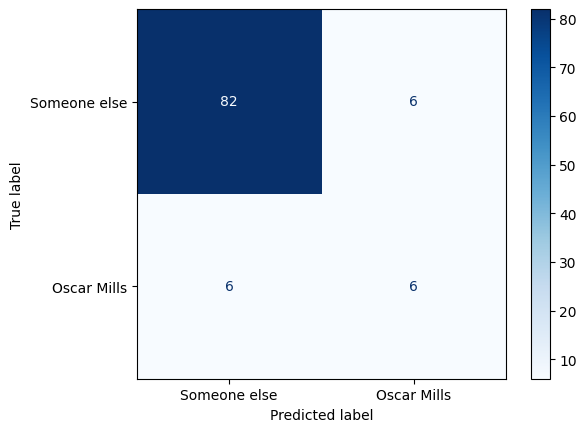

In [13]:
predicted_labels = eval(model, df.text.values)
generate_confusion_matrix(model, df, predicted_labels, narrator)

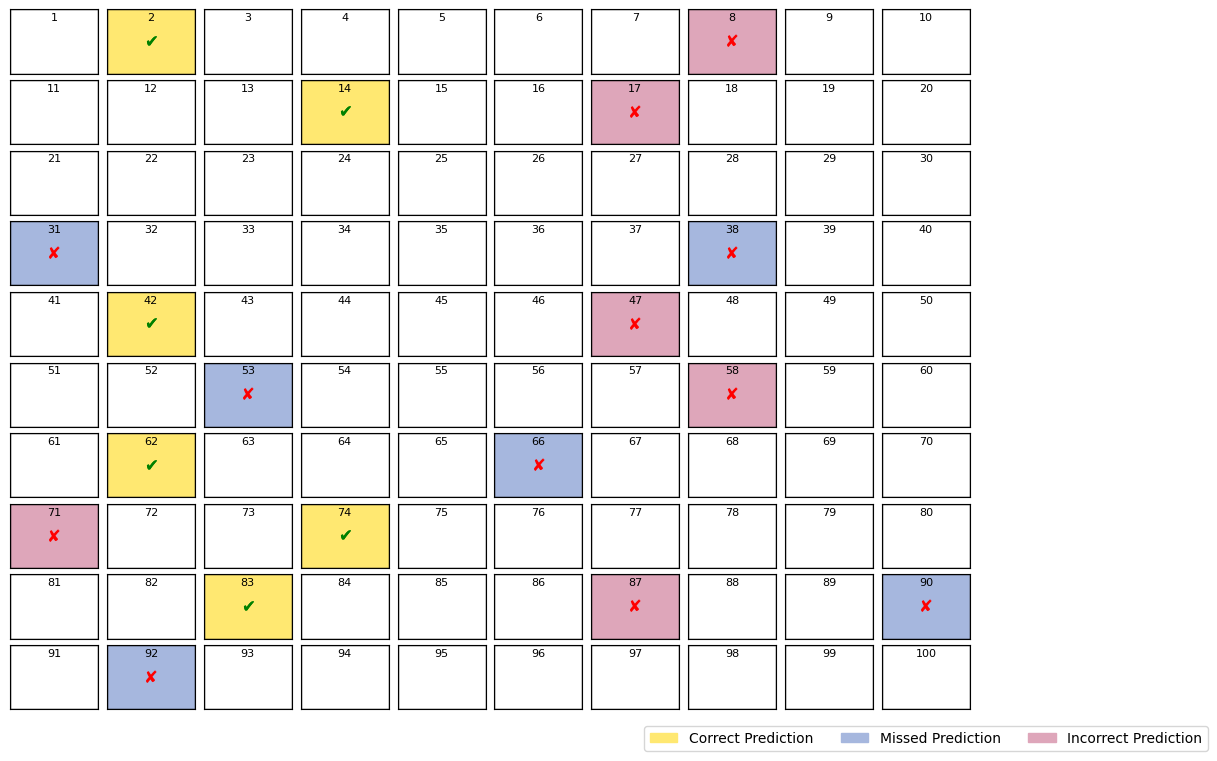

In [14]:
represent_pages(df, narrator)

## May Doncaster
<img src="https://glthr.com/cj/characters/may-min.jpg" alt="drawing" width="400"/>

In [15]:
narrator = "May Doncaster"
model = train(df, narrator)

Train dataset size: 23
1/20 — loss: 0.5362
2/20 — loss: 0.4939
3/20 — loss: 0.4743
4/20 — loss: 0.4622
5/20 — loss: 0.3953
6/20 — loss: 0.3452
7/20 — loss: 0.2691
8/20 — loss: 0.2197
9/20 — loss: 0.1787
10/20 — loss: 0.1397
11/20 — loss: 0.1108
12/20 — loss: 0.0846
13/20 — loss: 0.0631
14/20 — loss: 0.0492
15/20 — loss: 0.0376
16/20 — loss: 0.0309
17/20 — loss: 0.0228
18/20 — loss: 0.0192
19/20 — loss: 0.0170
20/20 — loss: 0.0144


<Figure size 800x600 with 0 Axes>

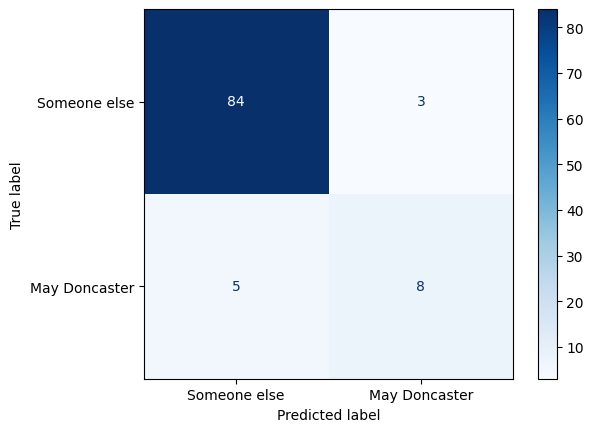

In [16]:
predicted_labels = eval(model, df.text.values)
generate_confusion_matrix(model, df, predicted_labels, narrator)

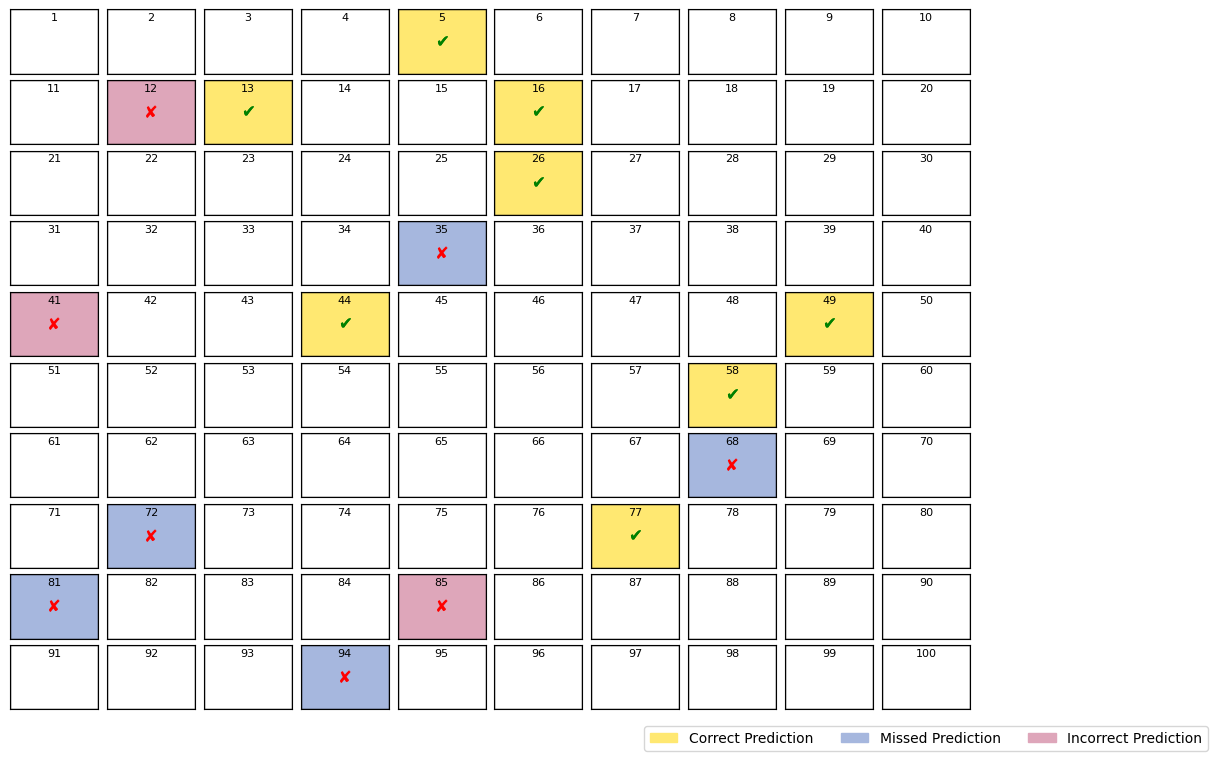

In [17]:
represent_pages(df, narrator)

## Sir Paul Trinder
<img src="https://glthr.com/cj/characters/paul-min.jpg" alt="drawing" width="400"/>

In [18]:
narrator = "Sir Paul Trinder"
model = train(df, narrator)

Train dataset size: 23
1/20 — loss: 0.5695
2/20 — loss: 0.5035
3/20 — loss: 0.4549
4/20 — loss: 0.4152
5/20 — loss: 0.3341
6/20 — loss: 0.2714
7/20 — loss: 0.2082
8/20 — loss: 0.1859
9/20 — loss: 0.1386
10/20 — loss: 0.1117
11/20 — loss: 0.1025
12/20 — loss: 0.0883
13/20 — loss: 0.0804
14/20 — loss: 0.0597
15/20 — loss: 0.0604
16/20 — loss: 0.0481
17/20 — loss: 0.0423
18/20 — loss: 0.0319
19/20 — loss: 0.0300
20/20 — loss: 0.0241


<Figure size 800x600 with 0 Axes>

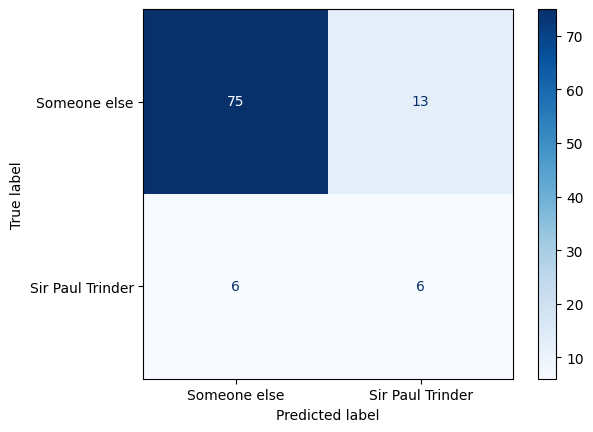

In [19]:
predicted_labels = eval(model, df.text.values)
generate_confusion_matrix(model, df, predicted_labels, narrator)

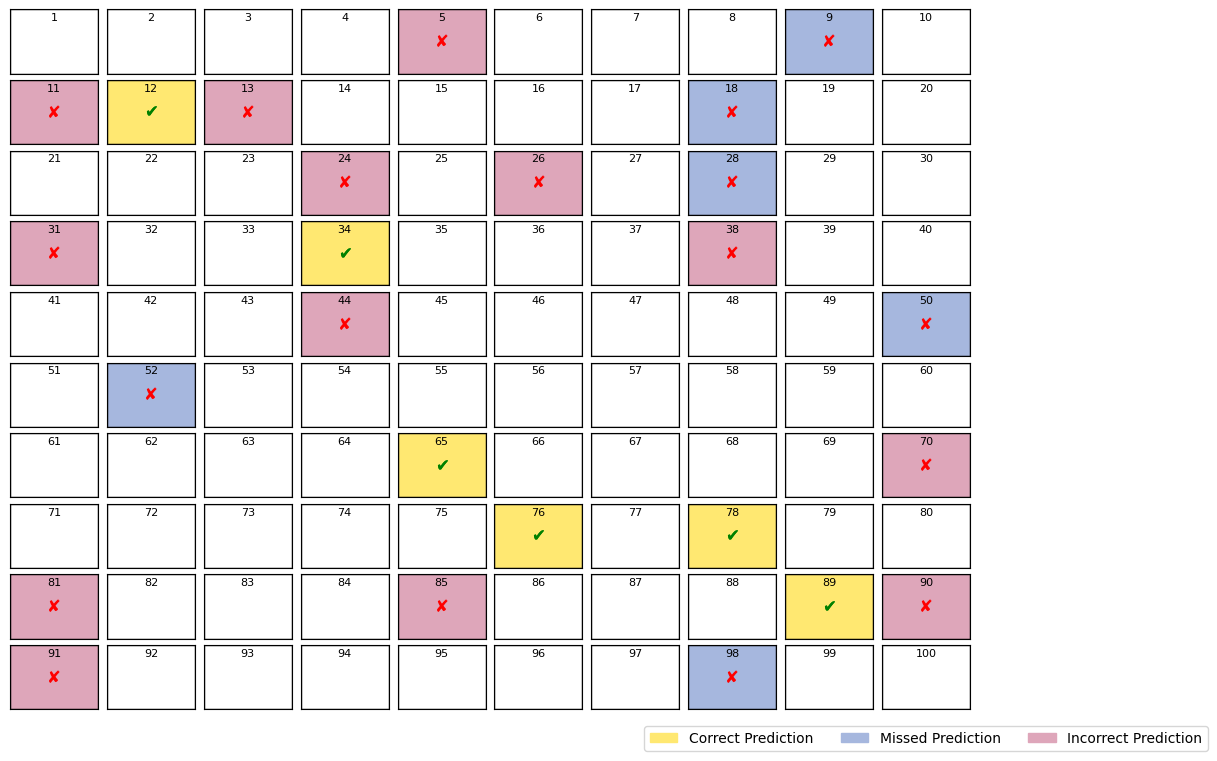

In [20]:
represent_pages(df, narrator)

## Clement DeAth
<img src="https://glthr.com/cj/characters/clement-min.jpg" alt="drawing" width="400"/>

In [21]:
narrator = "Clement DeAth"
model = train(df, narrator)

Train dataset size: 23
1/20 — loss: 0.5692
2/20 — loss: 0.4880
3/20 — loss: 0.4628
4/20 — loss: 0.4008
5/20 — loss: 0.3306
6/20 — loss: 0.2778
7/20 — loss: 0.2347
8/20 — loss: 0.1779
9/20 — loss: 0.1530
10/20 — loss: 0.1074
11/20 — loss: 0.0826
12/20 — loss: 0.0623
13/20 — loss: 0.0475
14/20 — loss: 0.0381
15/20 — loss: 0.0308
16/20 — loss: 0.0253
17/20 — loss: 0.0211
18/20 — loss: 0.0189
19/20 — loss: 0.0165
20/20 — loss: 0.0150


<Figure size 800x600 with 0 Axes>

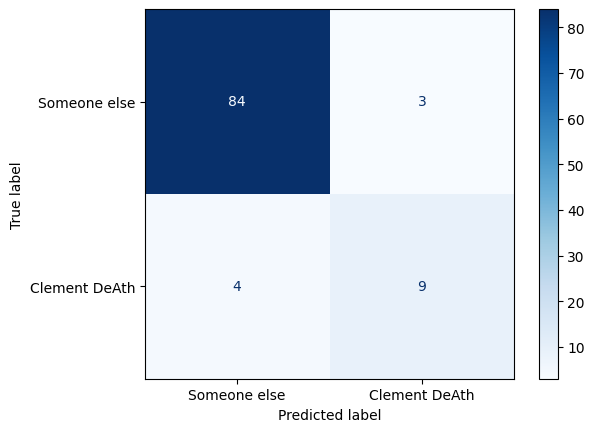

In [22]:
predicted_labels = eval(model, df.text.values)
generate_confusion_matrix(model, df, predicted_labels, narrator)

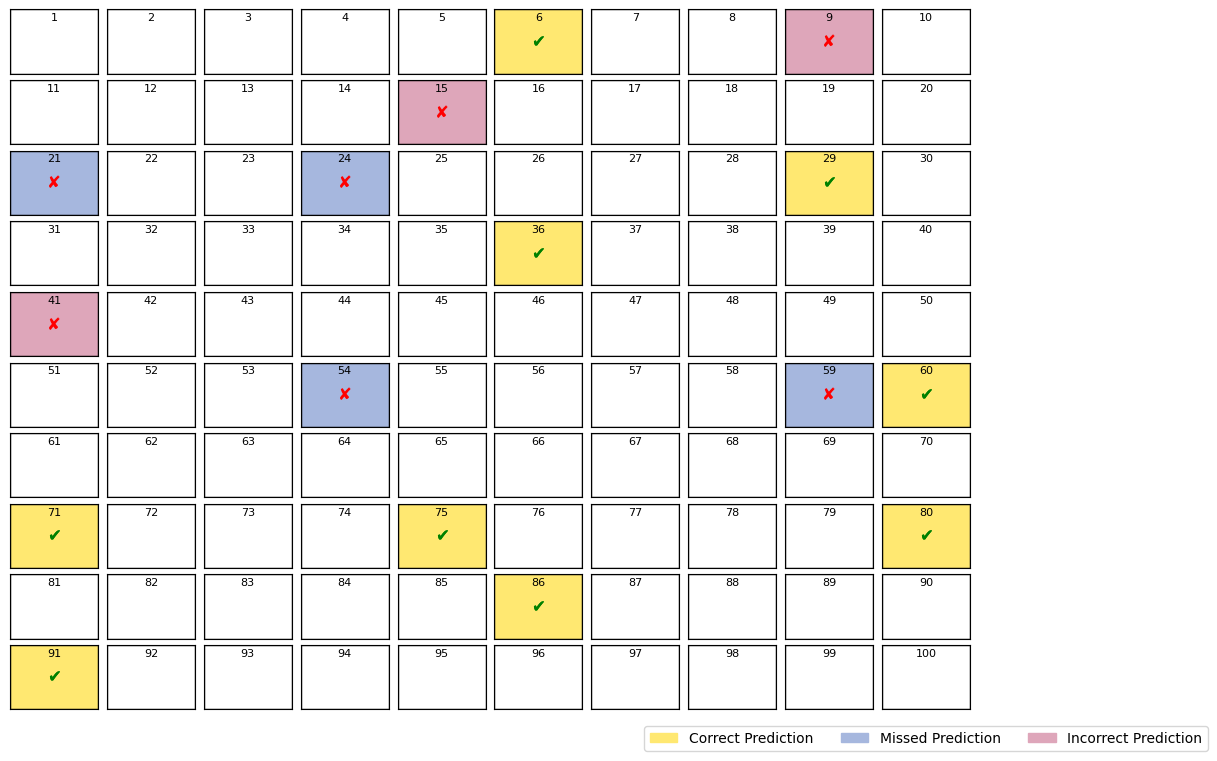

In [23]:
represent_pages(df, narrator)

## Bill Hardy
<img src="https://glthr.com/cj/characters/bill-min.jpg" alt="drawing" width="400"/>

In [24]:
narrator = "Bill Hardy"
model = train(df, narrator)

Train dataset size: 23
1/20 — loss: 0.5254
2/20 — loss: 0.4586
3/20 — loss: 0.4223
4/20 — loss: 0.3294
5/20 — loss: 0.2504
6/20 — loss: 0.1967
7/20 — loss: 0.1410
8/20 — loss: 0.1032
9/20 — loss: 0.0774
10/20 — loss: 0.0585
11/20 — loss: 0.0466
12/20 — loss: 0.0352
13/20 — loss: 0.0322
14/20 — loss: 0.0264
15/20 — loss: 0.0226
16/20 — loss: 0.0197
17/20 — loss: 0.0162
18/20 — loss: 0.0143
19/20 — loss: 0.0136
20/20 — loss: 0.0122


<Figure size 800x600 with 0 Axes>

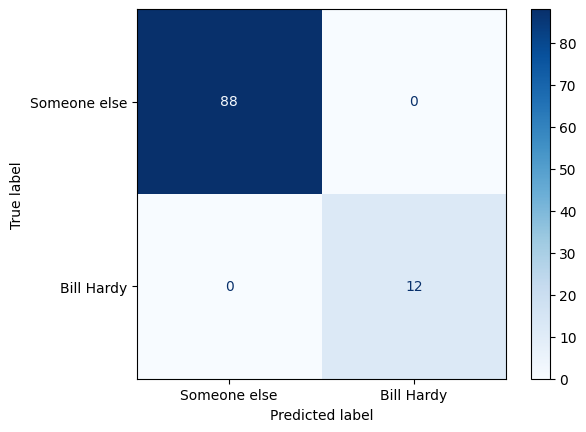

In [25]:
predicted_labels = eval(model, df.text.values)
generate_confusion_matrix(model, df, predicted_labels, narrator)

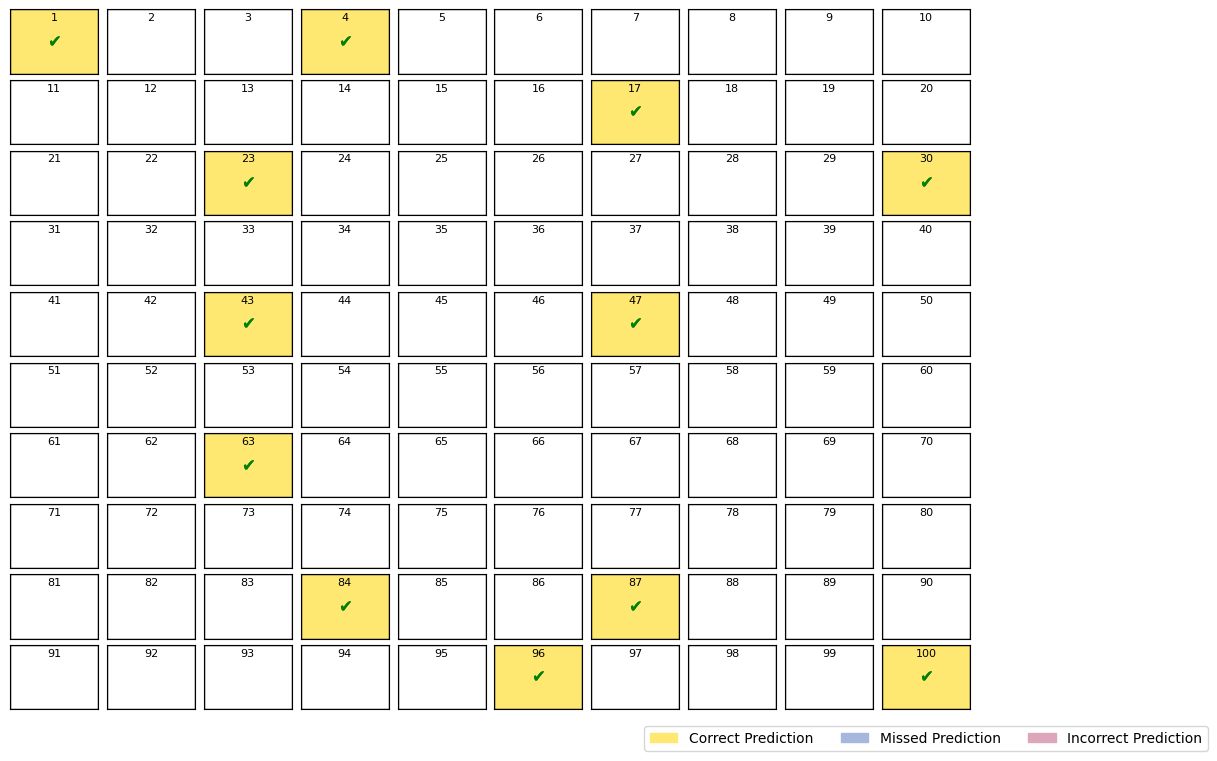

In [26]:
represent_pages(df, narrator)

## Jasmine Gay
<img src="https://glthr.com/cj/characters/jasmine-min.jpg" alt="drawing" width="400"/>

In [27]:
narrator = "Jasmine Gay"
model = train(df, narrator)

Train dataset size: 23
1/20 — loss: 0.5523
2/20 — loss: 0.4866
3/20 — loss: 0.4563
4/20 — loss: 0.4162
5/20 — loss: 0.3625
6/20 — loss: 0.2952
7/20 — loss: 0.2298
8/20 — loss: 0.2003
9/20 — loss: 0.1592
10/20 — loss: 0.1263
11/20 — loss: 0.0951
12/20 — loss: 0.0767
13/20 — loss: 0.0543
14/20 — loss: 0.0409
15/20 — loss: 0.0317
16/20 — loss: 0.0279
17/20 — loss: 0.0237
18/20 — loss: 0.0177
19/20 — loss: 0.0175
20/20 — loss: 0.0141


<Figure size 800x600 with 0 Axes>

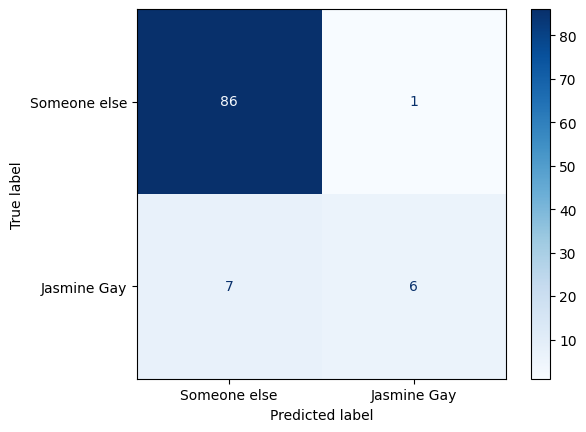

In [28]:
predicted_labels = eval(model, df.text.values)
generate_confusion_matrix(model, df, predicted_labels, narrator)

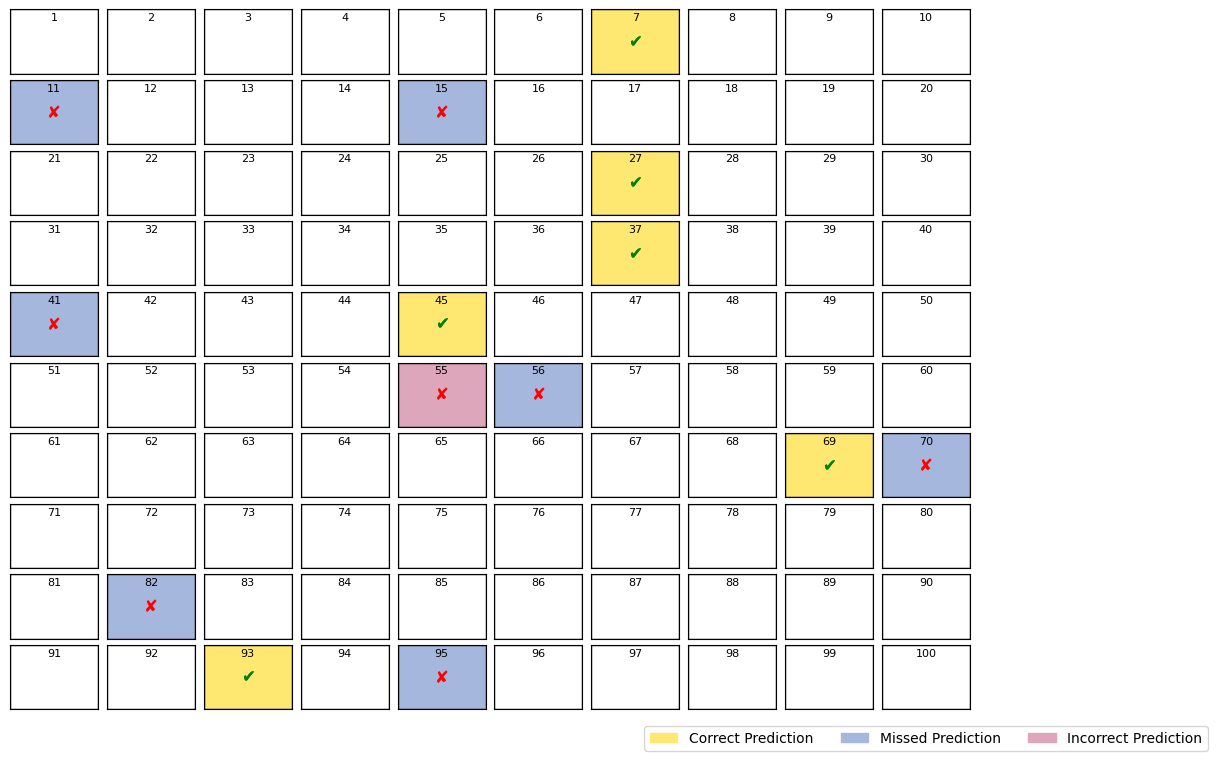

In [29]:
represent_pages(df, narrator)

## John Walker
<img src="https://glthr.com/cj/characters/john-min.jpg" alt="drawing" width="400"/>

In [30]:
narrator = "John Walker"
model = train(df, narrator)

Train dataset size: 23
1/20 — loss: 0.5844
2/20 — loss: 0.4710
3/20 — loss: 0.4381
4/20 — loss: 0.3220
5/20 — loss: 0.2537
6/20 — loss: 0.2084
7/20 — loss: 0.1678
8/20 — loss: 0.1489
9/20 — loss: 0.1299
10/20 — loss: 0.1160
11/20 — loss: 0.1038
12/20 — loss: 0.1000
13/20 — loss: 0.0903
14/20 — loss: 0.0806
15/20 — loss: 0.0697
16/20 — loss: 0.0609
17/20 — loss: 0.0563
18/20 — loss: 0.0516
19/20 — loss: 0.0470
20/20 — loss: 0.0387


<Figure size 800x600 with 0 Axes>

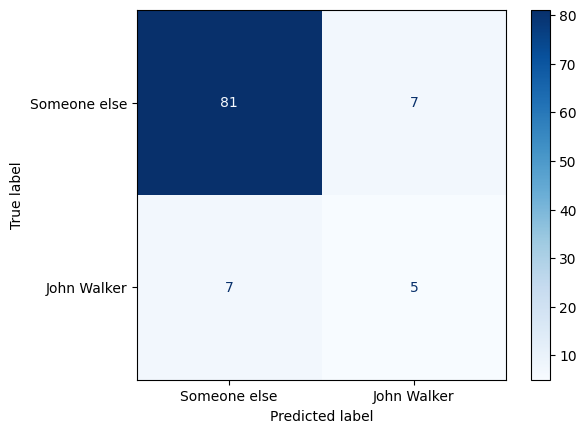

In [31]:
predicted_labels = eval(model, df.text.values)
generate_confusion_matrix(model, df, predicted_labels, narrator)

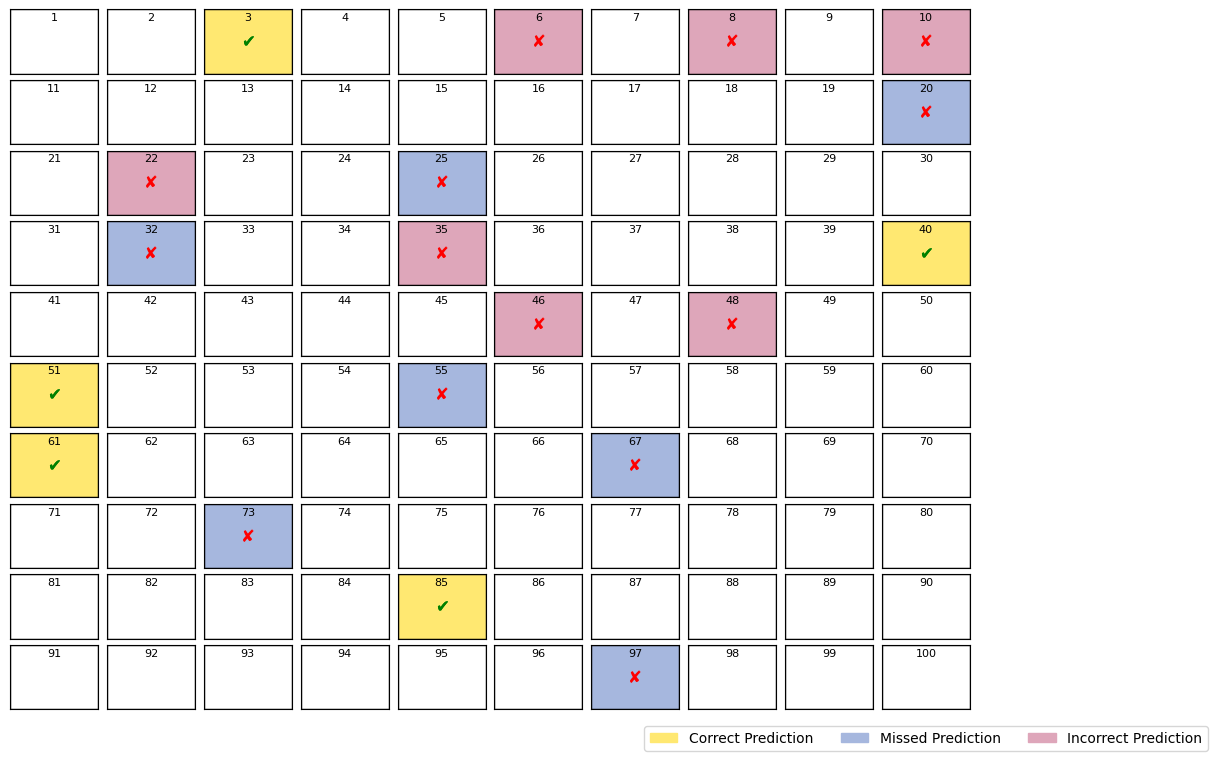

In [32]:
represent_pages(df, narrator)

## Henry (dog)
<img src="https://glthr.com/cj/characters/henry-min.jpg" alt="drawing" width="400"/>

In [33]:
narrator = "Henry (dog)"
model = train(df, narrator)

Train dataset size: 23
1/20 — loss: 0.5453
2/20 — loss: 0.4915
3/20 — loss: 0.4729
4/20 — loss: 0.3719
5/20 — loss: 0.2761
6/20 — loss: 0.2160
7/20 — loss: 0.1857
8/20 — loss: 0.1414
9/20 — loss: 0.1304
10/20 — loss: 0.1113
11/20 — loss: 0.1031
12/20 — loss: 0.0939
13/20 — loss: 0.0822
14/20 — loss: 0.0678
15/20 — loss: 0.0607
16/20 — loss: 0.0546
17/20 — loss: 0.0468
18/20 — loss: 0.0393
19/20 — loss: 0.0325
20/20 — loss: 0.0306


<Figure size 800x600 with 0 Axes>

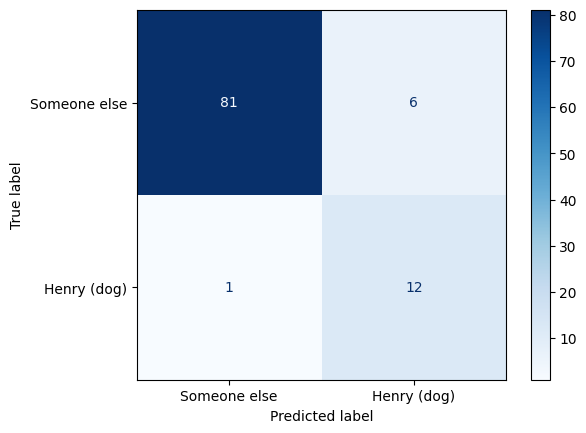

In [34]:
predicted_labels = eval(model, df.text.values)
generate_confusion_matrix(model, df, predicted_labels, narrator)

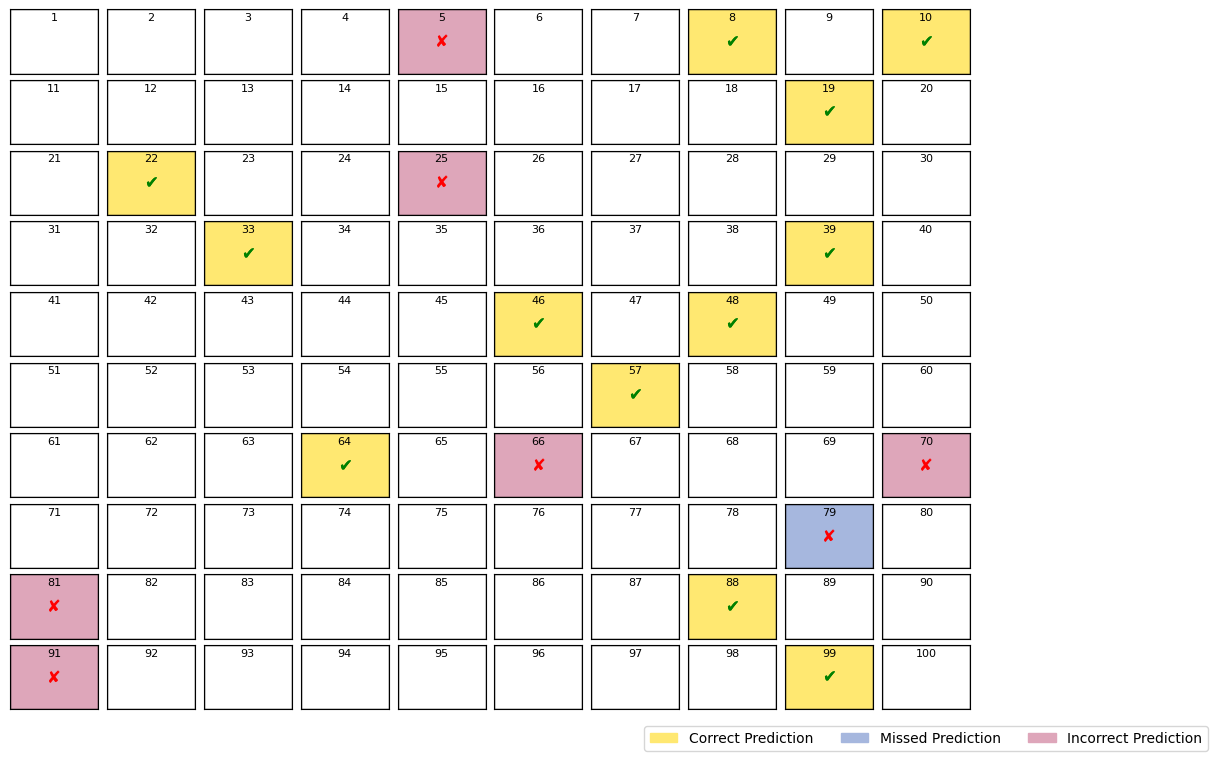

In [35]:
represent_pages(df, narrator)

# Analysis

Applying binary classification to all narrators reveals a compelling finding: Bill Hardy is the only narrator who can be reliably identified, confirming the observation of the multiclass classification results.

Consequently, pages belonging to Bill Hardy have characteristics that distinguish them from other narrators—from the model perspective.

_(TODO: to complete)_